Connected to GEO (Python 3.8.12)

In [2]:
import os
from glob import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from osgeo import gdal
from config import DATA_PATH, IMAGE_PATH, MODELS_PATH
from read_images import read_image_data
from image_to_data import raster_to_table, result_to_raster, raster_dic_to_array
from model import predict

c:\Users\Avalanche\anaconda3\envs\GEO\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def get_data_from_geo_image(im_paths = os.path.join(IMAGE_PATH, 'VailPass', '*.tiff'), res=10):
    
    rasters_dic, geo_transform = read_image_data(im_paths)
    pyr_levels = int(np.log2(res//10))
    rastes_array = raster_dic_to_array(rasters_dic, pyr_levels=res//10)
    n_rows, n_cols, _ = rastes_array.shape
    data_points = []
    for x in range(1, n_cols-1):
        for y in range(1, n_rows-1):
            point_data = rastes_array[y-1:y+2, x-1:x+2, :].flatten()
            data_points.append(point_data)
    data = pd.DataFrame(data_points)
    
    return data, rastes_array, geo_transform

In [3]:
def get_predictions(resolution, 
                    training_data, 
                    predict_data):
    
    traning_data = pd.read_csv(os.path.join(DATA_PATH, f"{res}_m_res.csv"))
    predictions, probalilities = predict(resolution=resolution, 
                                         training_data=traning_data, 
                                         predict_data=predict_data)
    
    return predictions, probalilities

In [4]:
def show_results(original_img, pred_img, prob_img, res=10):
    fig, ax = plt.subplots(nrows=3, figsize=(12,12))
    # sat_image = np.flip(rastes_array[...,:3], axis=-1) * 5

    ax[0].imshow(original_img)
    ax[0].set_title(f"Sentinel {res}m by {res}m image")
    ax[1].imshow(pred_img, cmap='gray')
    ax[1].set_title("Forest prediction")
    im = ax[2].imshow(prob_img, cmap='jet')
    ax[2].set_title("Prediction Probabilities ")
    plt.colorbar(im, ax=ax[2])
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


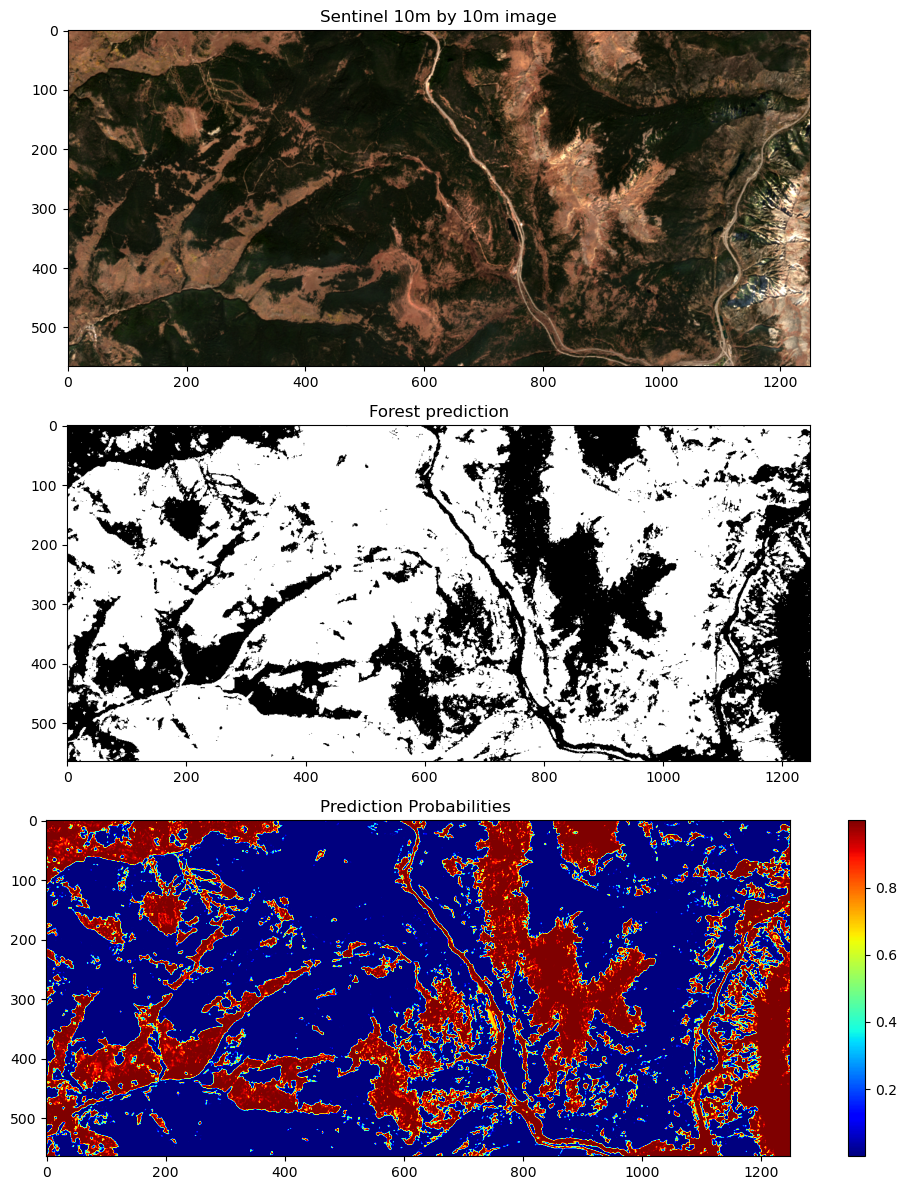

In [7]:
res = 10
data, rastes_array, geo_transform = get_data_from_geo_image(res=res)
traning_data = pd.read_csv(os.path.join(DATA_PATH, f"{res}_m_res.csv"))
predictions, probalilities = get_predictions(resolution=res, 
                                             training_data=traning_data, 
                                             predict_data=data)
shape = rastes_array.shape[:2]
results_img = result_to_raster(predictions, shape, geo_transform)
prob_img = result_to_raster(probalilities[:,0], shape, geo_transform)
sat_img = np.flip(rastes_array[...,:3], axis=-1) * 5
show_results(sat_img, results_img, prob_img, res=res)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


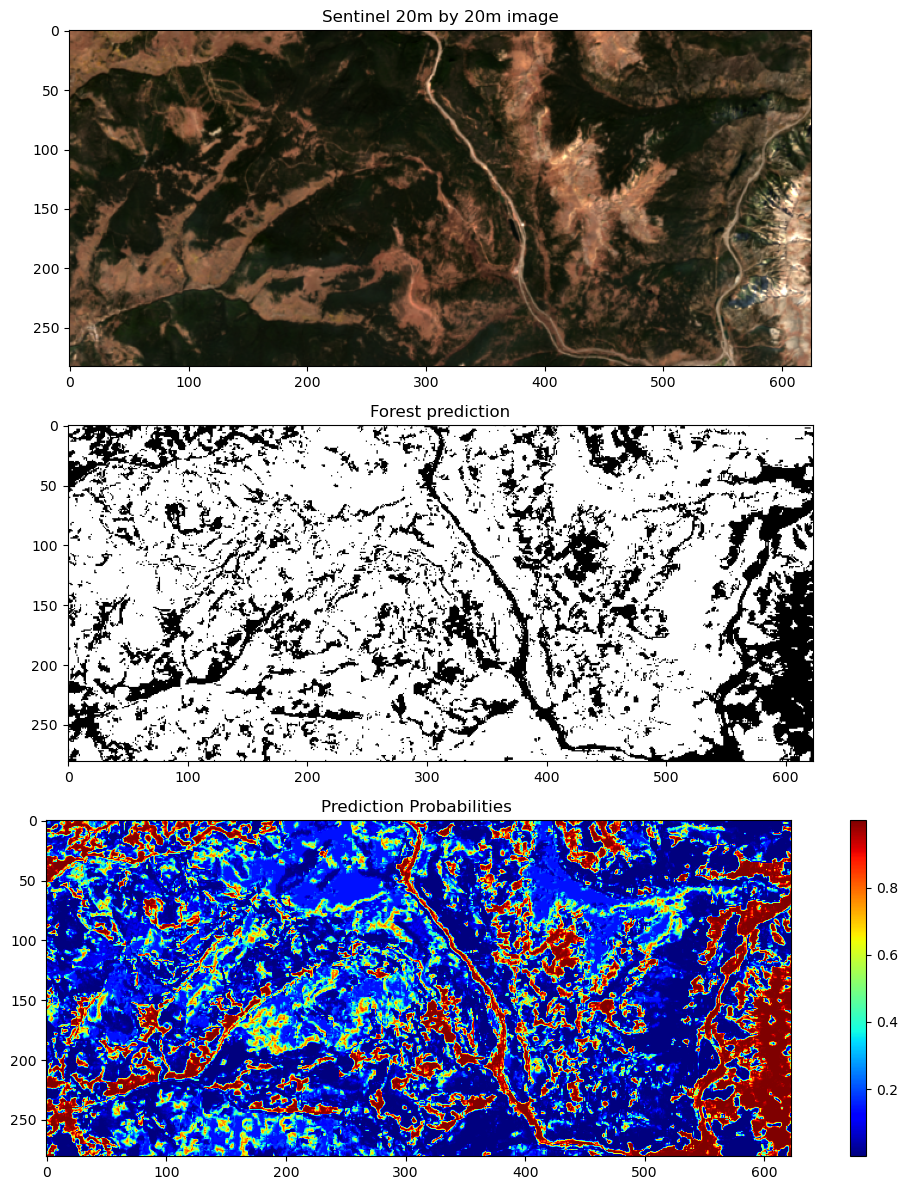

In [8]:
res = 20

data, rastes_array, geo_transform = get_data_from_geo_image(res=res)
traning_data = pd.read_csv(os.path.join(DATA_PATH, f"{res}_m_res.csv"))
predictions, probalilities = get_predictions(resolution=res, 
                                             training_data=traning_data, 
                                             predict_data=data)
shape = rastes_array.shape[:2]
results_img = result_to_raster(predictions, shape, geo_transform)
prob_img = result_to_raster(probalilities[:,0], shape, geo_transform)
sat_img = np.flip(rastes_array[...,:3], axis=-1) * 5
show_results(sat_img, results_img, prob_img, res=res)

Model Evaluation (10m res)

In [9]:
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

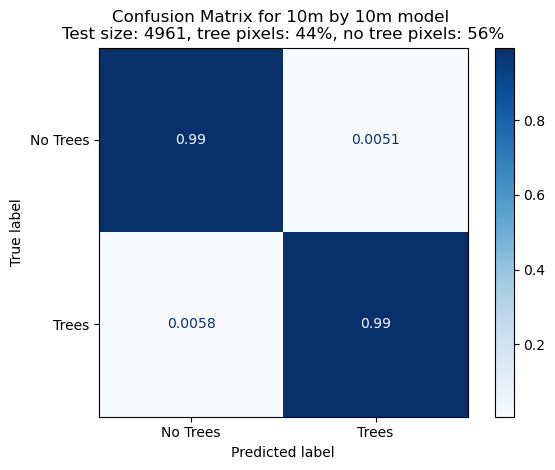

In [17]:
res = 10
traning_data = pd.read_csv(os.path.join(DATA_PATH, f"{res}_m_res.csv"))

X_train, X_test, y_train, y_test = train_test_split(traning_data.iloc[:, :-1], 
                                                    traning_data['target'], 
                                                    test_size=.2, 
                                                    random_state=42)  
with open(f'../models/{res}_m_model_params.json', 'r') as pf:
    modem_params = json.load(pf)

model = xgb.XGBClassifier(**modem_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Trees', 'Trees'])
disp.plot(cmap=plt.cm.Blues)
n_trees = int(100 * sum(y_test) / len(y_test))
plt.title(f'Confusion Matrix for {res}m by {res}m model \nTest size: {len(y_test)}, tree pixels: {n_trees}%, no tree pixels: {100-n_trees}%')
plt.tight_layout()
plt.show()

In [24]:
df = pd.read_csv("10_m_results_eval.csv")
df_tt = df.query('y_test == y_pred_NT and y_test == 1').reset_index()
df_ff = df.query('y_test == y_pred_NT and y_test == 0').reset_index()
df_tf = df.query('y_test != y_pred_NT and y_test == 1').reset_index()
df_ft = df.query('y_test != y_pred_NT and y_test == 0').reset_index()
plt_df = pd.concat([df_tt['y_prob'], df_ff['y_prob'], df_ft['y_prob'], df_tf['y_prob'],], axis=1)
plt_df.columns = [f"True traget - True pred \n(n={len(df_tt)})", f"False traget - Flase pred \n(n={len(df_ff)})",
                  f"True traget - Flase pred \n(n={len(df_tf)})", f"False traget - True pred \n(n={len(df_ft)})"]


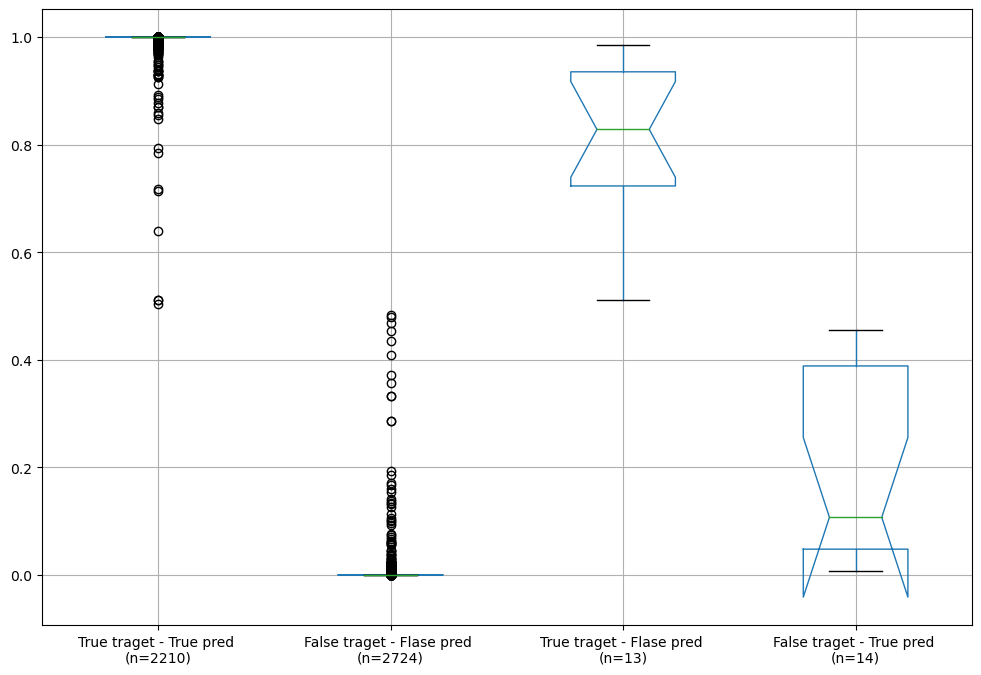

In [25]:
fig, ax  = plt.subplots(figsize=(12,8))
plt_df.boxplot(notch=True)
plt.show()

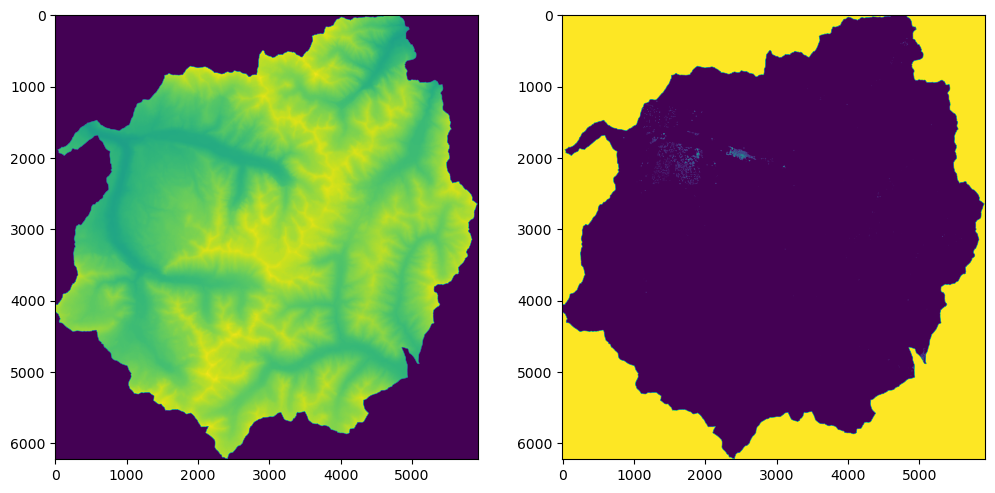

In [8]:
ds = gdal.Open('../data/images/DSM_telluride.tif')
ds.RasterCount
im1 = np.array(ds.GetRasterBand(1).ReadAsArray())
ds = None
ds = gdal.Open('../data/images/vegitation.tif')
ds.RasterCount
im2 = np.array(ds.GetRasterBand(1).ReadAsArray())
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,8))
ax1.imshow(im1)
ax2.imshow(im2)
ds = None

In [3]:

ds = gdal.Open('../data/images/Telluride/Telluride_5m.tif')
if ds is None:
    print(gdal.GetLastErrorMsg())
else:
    print(f"Number of bands: {ds.RasterCount}")
    width = ds.RasterXSize
    height = ds.RasterYSize
    print("Width:", width)
    print("Height:", height)
    geotransform = ds.GetGeoTransform()
    pixel_size_x = geotransform[1]
    pixel_size_y = geotransform[5]

    print("Pixel size in X direction:", pixel_size_x)
    print("Pixel size in Y direction:", pixel_size_y)
    rasters = []
    for i in range(1, ds.RasterCount+1):
        print(f"Getting # {i} band")
        im = np.asarray(ds.GetRasterBand(i).ReadAsArray())
        rasters.append(im)
    ds = None
    img = np.stack(rasters, axis=-1)

c:\Users\Avalanche\anaconda3\envs\GEO\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Number of bands: 3
Width: 8327
Height: 8112
Pixel size in X direction: 5.000120091269364
Pixel size in Y direction: -5.000246548323472
Getting # 1 band
Getting # 2 band
Getting # 3 band


In [4]:
plt.imsave('../data/images/Telluride/Telluride_5m.png', img)

In [5]:
img.shape

(8112, 8327, 3)